# Song Information Grabber

The goal is to grab information of the song that could possibly help the Neural Network with weights and etc...

By: 
- Andrew Angulo
- Daniel Ziabicki
- Liam Quinlan

In [65]:
%pip install librosa
%pip install numpy
%pip install pandas
%pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip in

In [2]:
import os
import json
import math
import librosa
import numpy as np
import pandas as pd
from tensorflow import keras
import matplotlib.pyplot as plt
import librosa, librosa.display
from os.path import dirname, join as pjoin

/Users/andrewangulo/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


---
# Grabbing The Song

In [3]:
# Get the current working directory (where your notebook/script is running)
current_dir = os.getcwd()

# Build the path to the Test_Songs folder
data_dir = pjoin(current_dir, 'Test_Songs')
files_in_directory = os.listdir(data_dir)

# Full path to the song
song_path = pjoin(data_dir, files_in_directory[-1])

wav_files = [f for f in files_in_directory if f.lower().endswith('.wav')]

---
# Understanding the data within the Song file

Utilizing the documentation to understand the data from the example song file

[Librosa Documentation](https://librosa.org/doc/latest/index.html)

[I followed this guide](https://www.youtube.com/watch?v=Oa_d-zaUti8&list=PL-wATfeyAMNrtbkCNsLcpoAyBBRJZVlnf&index=11)

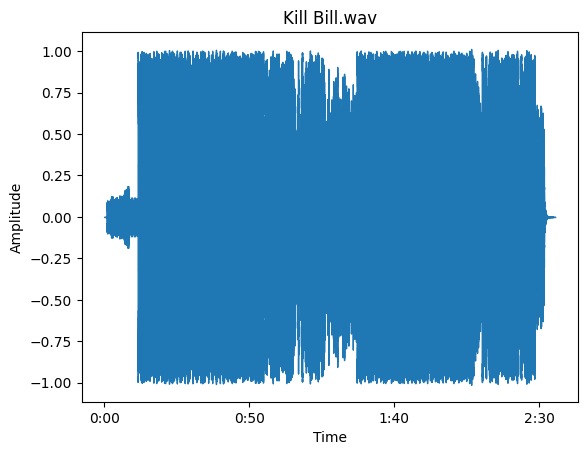

In [4]:
audio_data, sample_rate = librosa.load(song_path, sr=22050)
librosa.display.waveshow(audio_data, sr=sample_rate)
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.title(files_in_directory[-1])
plt.show()

In [5]:
fft = np.fft.fft(audio_data)
magnitude = np.abs(fft)
frequency = np.linspace(0, sample_rate, len(magnitude))

left_frequency = frequency[:int(len(frequency)/2)]
left_magnitude = magnitude[:int(len(frequency)/2)]

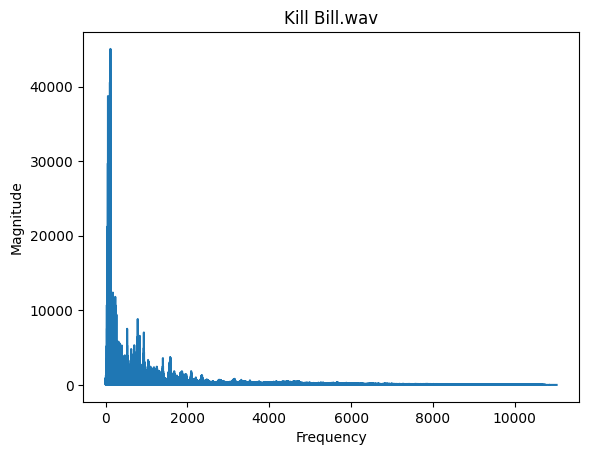

In [6]:
plt.plot(left_frequency, left_magnitude)
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.title(files_in_directory[-1])
plt.show()

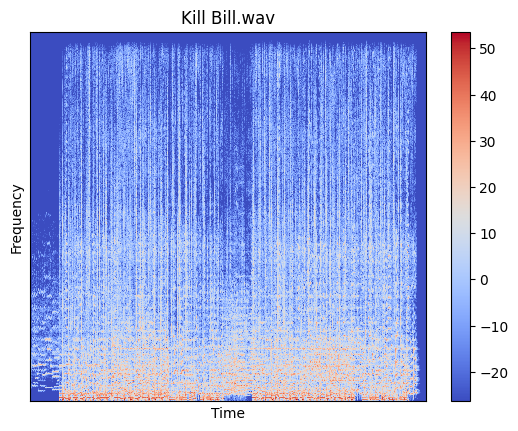

In [7]:
n_fft = 2048 # number of samples
hop_length = 512 # amount we shift each fft to the right


stft = librosa.core.stft(audio_data, hop_length = hop_length, n_fft = n_fft)

spectrogram = np.abs(stft)
log_spectrogram = librosa.amplitude_to_db(spectrogram)


librosa.display.specshow(log_spectrogram, sr = sample_rate, hop_length = hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar()
plt.title(files_in_directory[-1])
plt.show()

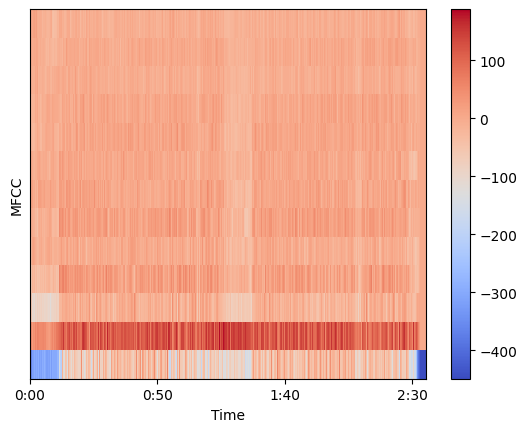

In [8]:
# MFCC
MFCCs = librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_fft=n_fft, hop_length=hop_length, n_mfcc=13)

librosa.display.specshow(MFCCs, sr=sample_rate, hop_length=hop_length, x_axis='time')
plt.xlabel("Time")
plt.ylabel("MFCC")
plt.colorbar()
plt.show()


In [9]:
# Function to preprocess the new song
def preprocess_song(file_path, segment_duration=3):
    SAMPLE_RATE = 22050
    n_mfcc = 13
    n_fft = 2048
    hop_length = 512

    signal, sr = librosa.load(file_path, sr=SAMPLE_RATE)

    signal_length = len(signal)
    duration = signal_length / SAMPLE_RATE
    num_segments = int(duration / segment_duration)
    num_samples_per_segment = int(segment_duration * SAMPLE_RATE)
    expected_num_mfcc_vectors_per_segment = math.ceil(num_samples_per_segment / hop_length)

    song_mfcc = []
    for s in range(num_segments):
        start_sample = num_samples_per_segment * s
        finish_sample = start_sample + num_samples_per_segment

        if finish_sample > len(signal):
            break

        mfcc = librosa.feature.mfcc(y=signal[start_sample:finish_sample],
                                    sr=sr,
                                    n_fft=n_fft,
                                    n_mfcc=n_mfcc,
                                    hop_length=hop_length)
        mfcc = mfcc.T

        if len(mfcc) == expected_num_mfcc_vectors_per_segment:
            song_mfcc.append(mfcc.tolist())

    return song_mfcc

In [10]:
# Load the trained model and label mapping
model = keras.models.load_model("genre_classification_model.keras")
with open('label_mapping.json', 'r') as f:
    mapping = json.load(f)

print("Welcome To The Music Classifier Notebook")
print("Steps:\n---\n1) Place your .wav files into the 'Test_Songs' folder.\n---")

# Initialize an empty list to store results
results = []

# Path to the Test_Songs directory
current_dir = os.getcwd()
data_dir = os.path.join(current_dir, 'Test_Songs')

# List all files in the directory
files_in_directory = os.listdir(data_dir)

# Filter out files that end with .wav
wav_files = [f for f in files_in_directory if f.lower().endswith('.wav')]

if not wav_files:
    print("No .wav files found in the 'Test_Songs' directory.")
else:
    # Main loop to allow multiple inputs
    while True:
        result = input("Would you like to get the genre of each song or the most recent? (E/R)\nE: Everything\nR: Recent\nQ: Quit\n").strip().upper()
        if result == 'E':
            # Process all .wav files
            for file_name in wav_files:
                # print(f"\nProcessing file: {file_name}")
                file_path = os.path.join(data_dir, file_name)
                try:
                    # Preprocess the song (Assuming the function is defined elsewhere)
                    song_mfcc = preprocess_song(file_path, segment_duration=3)
                    X_new = np.array(song_mfcc)
                    if X_new.size == 0:
                        print(f"No valid segments found in {file_name}. Skipping.")
                        continue
                    # Make predictions
                    predictions = model.predict(X_new)
                    average_prediction = np.mean(predictions, axis=0)
                    predicted_index = np.argmax(average_prediction)
                    predicted_genre = mapping[predicted_index]
                    # print(f"The predicted genre for '{file_name}' is: {predicted_genre}")
                    # Append to results if not already in the list
                    result_tuple = (file_name, predicted_genre)
                    if result_tuple not in results:
                        results.append(result_tuple)
                except Exception as e:
                    print(f"An error occurred while processing '{file_name}': {e}")
        elif result == 'R':
            # Get recent .wav file
            full_paths = [os.path.join(data_dir, f) for f in wav_files]
            latest_file = max(full_paths, key=os.path.getmtime)
            latest_file_name = os.path.basename(latest_file)
            #print(f"\nProcessing the most recent file: {latest_file_name}")
            try:
                # Preprocess the song
                song_mfcc = preprocess_song(latest_file, segment_duration=3)
                X_new = np.array(song_mfcc)
                if X_new.size == 0:
                    print(f"No valid segments found in {latest_file_name}.")
                else:
                    # Make predictions
                    predictions = model.predict(X_new)
                    average_prediction = np.mean(predictions, axis=0)
                    predicted_index = np.argmax(average_prediction)
                    predicted_genre = mapping[predicted_index]
                    #print(f"The predicted genre for '{latest_file_name}' is: {predicted_genre}")
                    # Append to results if not already in the list
                    result_tuple = (latest_file_name, predicted_genre)
                    if result_tuple not in results:
                        results.append(result_tuple)
            except Exception as e:
                print(f"An error occurred while processing '{latest_file_name}': {e}")
        elif result == 'Q':
            # Quit the loop
            break
        else:
            print("Invalid input. Please enter 'E' for Everything, 'R' for Recent, or 'Q' to Quit.")

Welcome To The Music Classifier Notebook
Steps:
---
1) Place your .wav files into the 'Test_Songs' folder.
---
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


In [11]:
# After processing, print the results
print("\nFinal Results:\n---")

# Print each result line-by-line
for file_name, genre in results: 
    print(f"Song: {file_name[:-4]}\nGenre: {genre}\n---")


Final Results:
---
Song: Thick of It
Genre: country
---
